In [1]:
import gzip
from pathlib import Path

In [2]:
import h5py
import numpy as np
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from scipy.stats.stats import pearsonr
from matplotlib import pyplot as plt

In [3]:
#BASE_DIR = Path("/mnt/g/My Drive/CloudVault/Masters/Data")
BASE_DIR = Path("/home/jakob/Cloudvault_new/Data")

# Path of directory to get Graphpart output
GRAPHPART_DIR = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'06-partitioning'/'graphpart_partitions'

# Paths of imported embeddings file
EMBEDDING_FILE = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'05-embedding'/'protein_embeddings_netsurfp_output_glyc_labels_max.h5'

# Path of NetOGlyc 4 output (gzipped)
NETOGLYC4_OUTPUT = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'07-benchmarking'/'netoglyc4_predictions_GalNAc.gff.gz'

# Maximum sequence length of proteins for test set
#MAX_SEQ_LENGTH = 1022
MAX_SEQ_LENGTH = 34350

IGNORE_MISSING_IDS = True

In [4]:
GRAPHPART_OUTPUT_FILE = GRAPHPART_DIR/'graphpart_output.csv'

In [5]:
clusters = [set(), set(), set()]
with open(GRAPHPART_OUTPUT_FILE, 'r') as f:
    f_iter = iter(f)
    header = next(f_iter).strip().split(',')
    for line in f_iter:
        AC, priority, glycosylated, cluster = line.strip().split(',')
        priority = priority == "True"
        glycosylated = float(glycosylated) > 0
        cluster = int(float(cluster))
        clusters[cluster].add(AC)

testing_ids = clusters[2]

len(testing_ids)

267

In [6]:
with h5py.File(EMBEDDING_FILE, 'r') as file:
    identifiers_list = file['identifiers'].asstr()[:].tolist()
    sequences_list = file['sequences'].asstr()[:].tolist()
    seq_lengths = [len(seq) for seq in sequences_list]
    gly = file['labels']['gly'][:, :MAX_SEQ_LENGTH, 0]

In [7]:
#testing_ids = set(identifiers_list)

In [8]:
identifier_scores = {}
duplicate_identifiers = set()
last_identifier = ''
last_idx = 0

with gzip.open(NETOGLYC4_OUTPUT, 'r') as f:
    for line in f:
        line = line.decode().strip()
        if not line.startswith('#'):
            seqname, source, feature, start, end, score, strand, frame, *comment = line.split(maxsplit=7)
            start_idx = int(start) - 1
            end_idx = int(end) - 1
            if start_idx != end_idx:
                raise Exception(f"Different start and end indices for line: {line}")
            score = float(score)
            if seqname != last_identifier:
                if seqname not in identifier_scores:
                    if start_idx < MAX_SEQ_LENGTH:
                        identifier_scores[seqname] = [(start_idx, score)]
                    last_identifier = seqname
                    last_idx = start_idx
                else:
                    duplicate_identifiers.add(seqname)
            elif start_idx <= last_idx:
                duplicate_identifiers.add(seqname)
            else:
                if start_idx < MAX_SEQ_LENGTH:
                    identifier_scores[seqname].append((start_idx, score))
                last_idx = start_idx

In [9]:
print(f"Maximum sequence length in output: {max(idx for scores in identifier_scores.values() for idx, score in scores) + 1}")

Maximum sequence length in output: 14499


In [10]:
if len(duplicate_identifiers) > 0:
    raise KeyError(f"Duplicate results were found for following identifiers, check whether duplicates are truncated identifiers: {duplicate_identifiers}")

missing_embedding_identifiers = set(testing_ids) - set(identifiers_list)
if len(missing_embedding_identifiers) > 0:
    if not IGNORE_MISSING_IDS:
        raise Exception(f"{len(missing_embedding_identifiers)} test identifiers not found in embeddings: {missing_embedding_identifiers}")

missing_scoring_identifiers = set(testing_ids) - set(identifier_scores)
if len(missing_scoring_identifiers) > 0:
    if not IGNORE_MISSING_IDS:
        raise Exception(f"{len(missing_scoring_identifiers)} test identifiers not found in scores: {missing_scoring_identifiers}")

missing_identifiers = missing_embedding_identifiers | missing_scoring_identifiers
if len(missing_identifiers) > 0:
    print(f"Ignoring following {len(missing_identifiers)} missing test identifiers: {missing_identifiers}")

testing_scores = {protein_id: identifier_scores[protein_id] for protein_id in (testing_ids - missing_identifiers)}

In [11]:
ambiguous_pred = []
ambiguous_labels = []

unambiguous_pred = []
unambiguous_labels = []

for identifier in testing_scores:
    scores = testing_scores[identifier]
    embedding_idx = identifiers_list.index(identifier)
    seq_length = min(len(sequences_list[embedding_idx]), MAX_SEQ_LENGTH)
    
    labels = gly[embedding_idx, :seq_length]
    ambiguous_site_mask = (labels >= 0) & (labels != 0) & (labels != 1)
    unambiguous_site_mask = (labels == 0) | (labels == 1)
    
    pred = np.zeros(seq_length)
    for idx, score in scores:
        pred[idx] = score
   
    ambiguous_pred.append(pred[ambiguous_site_mask])
    ambiguous_labels.append(labels[ambiguous_site_mask])
    
    unambiguous_pred.append(pred[unambiguous_site_mask])
    unambiguous_labels.append(labels[unambiguous_site_mask])

ambiguous_pred = np.concatenate(ambiguous_pred)
ambiguous_labels = np.concatenate(ambiguous_labels)

unambiguous_pred = np.concatenate(unambiguous_pred)
unambiguous_labels = np.concatenate(unambiguous_labels)

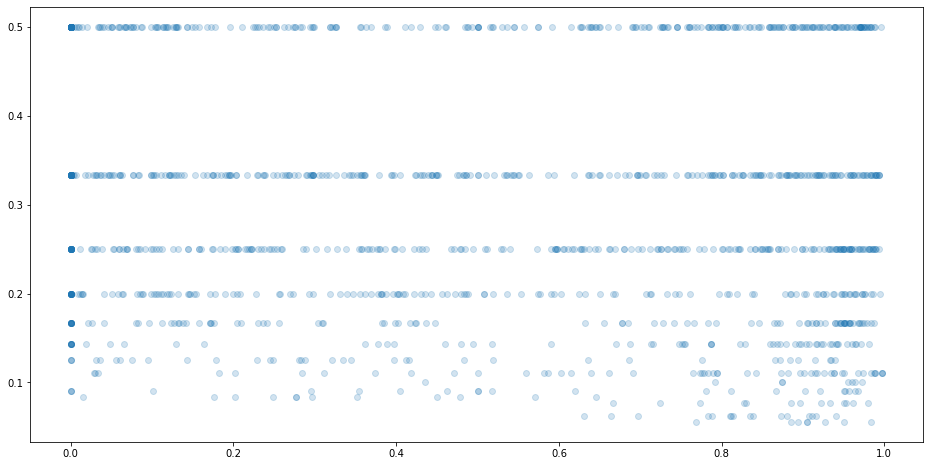

In [12]:
plt.figure(figsize=(16, 8))
plt.scatter(ambiguous_pred, ambiguous_labels, alpha=0.2)

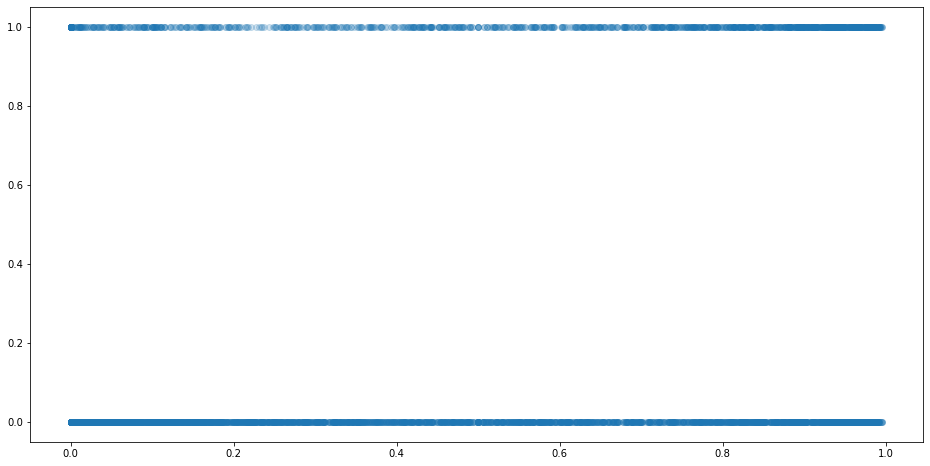

In [13]:
plt.figure(figsize=(16, 8))
plt.scatter(unambiguous_pred, unambiguous_labels, alpha=0.2)

In [14]:
def plot_roc_curve(labels, pred, title="Receiver operating characteristic"):
    fpr, tpr, _ = roc_curve(labels, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def calculate_metrics(ambiguous_labels, ambiguous_pred, unambiguous_labels, unambiguous_pred, ambiguous_labels_threshold=0.5, pred_threshold=0.5):
    print(f"% of unambiguous sites glycosylated: {(unambiguous_labels > 0).sum() / len(unambiguous_labels) * 100}")
    print(f"Accuracy for unambiguous sites: {accuracy_score(unambiguous_labels, (unambiguous_pred >= pred_threshold))}")
    print(f"MCC for unambiguous sites: {matthews_corrcoef(unambiguous_labels, (unambiguous_pred >= pred_threshold))}")
    print(f"PCC for unambiguous sites: {pearsonr(unambiguous_pred, unambiguous_labels)}")
    print(f"ROC-AUC for unambiguous sites: {roc_auc_score(unambiguous_labels, unambiguous_pred)}")
    
    tn, fp, fn, tp = confusion_matrix(unambiguous_labels, (unambiguous_pred >= pred_threshold)).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"Sensitivity (TPR) for unambiguous sites: {sensitivity*100:.2f}%")
    print(f"Specificity (TNR) for unambiguous sites: {specificity*100:.2f}%")
    
    plot_roc_curve(unambiguous_labels, unambiguous_pred, "Receiver operating characteristic for unambiguous sites")
    
    print(f"% of ambiguous sites glycosylated: {(ambiguous_labels > 0).sum() / len(ambiguous_labels) * 100}")
    print(f"Accuracy for ambiguous sites (threshold 0.5): {accuracy_score((ambiguous_labels >= ambiguous_labels_threshold), (ambiguous_pred >= pred_threshold))}")
    print(f"MCC for ambiguous sites (threshold 0.5): {matthews_corrcoef((ambiguous_labels >= ambiguous_labels_threshold), (ambiguous_pred >= pred_threshold))}")
    print(f"PCC for ambiguous sites: {pearsonr(ambiguous_pred, ambiguous_labels)}")
    print(f"ROC-AUC for ambiguous sites (threshold 0.5): {roc_auc_score((ambiguous_labels >= ambiguous_labels_threshold), ambiguous_pred)}")

    tn, fp, fn, tp = confusion_matrix((ambiguous_labels >= ambiguous_labels_threshold), (ambiguous_pred >= pred_threshold)).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"Sensitivity (TPR) for ambiguous sites (threshold 0.5): {sensitivity*100:.2f}%")
    print(f"Specificity (TNR) for ambiguous sites (threshold 0.5): {specificity*100:.2f}%")
    
    plot_roc_curve((ambiguous_labels >= ambiguous_labels_threshold), ambiguous_pred, "Receiver operating characteristic for ambiguous sites (threshold 0.5)")

NetOGlyc-4.0 predictions for test partition of NetOGlyc-5.0 'max' dataset (1277 ambiguous sites, 4634 unambiguous sites):

% of unambiguous sites glycosylated: 27.751402675873976
Accuracy for unambiguous sites: 0.6145878290893396
MCC for unambiguous sites: 0.23573228685651823
PCC for unambiguous sites: (0.27089656025513464, 9.417839569090649e-79)
ROC-AUC for unambiguous sites: 0.673939990635295
Sensitivity (TPR) for unambiguous sites: 66.95%
Specificity (TNR) for unambiguous sites: 59.35%


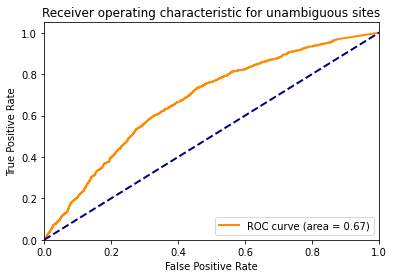

% of ambiguous sites glycosylated: 100.0
Accuracy for ambiguous sites (threshold 0.5): 0.485512920908379
MCC for ambiguous sites (threshold 0.5): -0.003066404547021302
PCC for ambiguous sites: (-0.10540346750679944, 0.00016101572646258234)
ROC-AUC for ambiguous sites (threshold 0.5): 0.4655208548065691
Sensitivity (TPR) for ambiguous sites (threshold 0.5): 52.19%
Specificity (TNR) for ambiguous sites (threshold 0.5): 47.45%


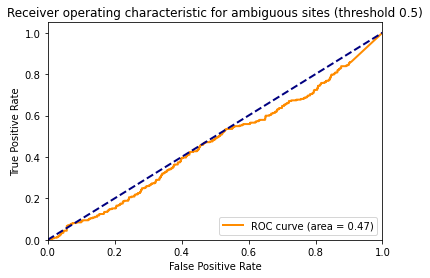

In [15]:
print(f"NetOGlyc-4.0 predictions for test partition of NetOGlyc-5.0 'max' dataset ({len(ambiguous_labels)} ambiguous sites, {len(unambiguous_labels)} unambiguous sites):\n")
calculate_metrics(ambiguous_labels, ambiguous_pred, unambiguous_labels, unambiguous_pred, ambiguous_labels_threshold=0.5, pred_threshold=0.5)